In [2]:
import json
from pathlib import Path
from collections import Counter

import matplotlib.pyplot as plt
import pandas as pd

import os

plt.style.use("ggplot")
pd.options.display.float_format = "{:,.3f}".format

In [3]:
# Resolve repo root even if the notebook is opened from sae_core/
repo_root = Path.cwd().resolve()
if repo_root.name == "sae_core":
    repo_root = repo_root.parent

feature_summ_path = repo_root / "Qwen_Qwen3-0.6B.blocks.9.hook_resid_post.btop128sae.all_science.exp4.analysis/results/feature_summaries_20251213_151033.jsonl"
print(f"Using feature summaries at: {feature_summ_path}")

with feature_summ_path.open() as f:
    feature_summaries = [json.loads(line) for line in f if line.strip()]

print(f"Loaded {len(feature_summaries):,} features")

Using feature summaries at: /Users/deancasey/Documents/Columbia/CRIS Lab/SAELens/Qwen_Qwen3-0.6B.blocks.9.hook_resid_post.btop128sae.all_science.exp4.analysis/results/feature_summaries_20251213_151033.jsonl
Loaded 3,464 features


In [4]:
feature_summaries[0].keys()

dict_keys(['feature', 'activation_frequency', 'mean_activation', 'top_examples'])

In [5]:
len(feature_summaries)

3464

In [6]:
df = pd.DataFrame(feature_summaries)
df["num_examples"] = df["top_examples"].apply(len)
df.head()

,feature,activation_frequency,mean_activation,top_examples,num_examples
0,0,"37,502.000",259.053,"[{'token': 'decay', 'activation': 322.02548217...",25
1,1,7.000,2.841,"[{'token': ' elements', 'activation': 7.251221...",7
2,2,11.000,1.106,"[{'token': 'ification', 'activation': 1.662285...",11
3,3,401.000,4.886,"[{'token': 'ification', 'activation': 16.29918...",25
4,4,1.000,0.815,"[{'token': ' their', 'activation': 0.814577281...",1


In [7]:
display(df[["activation_frequency", "mean_activation", "num_examples"]].describe())

print("Top by mean_activation")
top_mean = df.nlargest(10, "mean_activation")["feature activation_frequency mean_activation num_examples".split()]
display(top_mean)

print("Top by activation_frequency")
top_freq = df.nlargest(10, "activation_frequency")["feature activation_frequency mean_activation num_examples".split()]
display(top_freq)

,activation_frequency,mean_activation,num_examples
count,"3,464.000","3,464.000","3,464.000"
mean,"82,259.252",6.179,19.825
std,"207,721.438",28.237,9.159
min,1.000,0.313,1.000
25%,19.000,1.020,19.000
50%,"1,663.000",1.661,25.000
75%,"38,605.250",3.369,25.000
max,"2,210,975.000",431.049,25.000


Top by mean_activation


,feature,activation_frequency,mean_activation,num_examples
3176,3750,"52,039.000",431.049,25
444,528,"49,286.000",425.259,25
2827,3338,"47,786.000",420.744,25
154,179,"49,550.000",395.786,25
2780,3286,"38,154.000",346.858,25
3371,3987,"38,961.000",319.723,25
803,961,"40,356.000",317.257,25
3459,4090,"39,186.000",313.091,25
2124,2524,"38,504.000",303.640,25
646,769,"40,679.000",301.605,25


Top by activation_frequency


,feature,activation_frequency,mean_activation,num_examples
2393,2842,"2,210,975.000",31.674,25
3043,3593,"2,115,723.000",4.928,25
1444,1726,"2,075,604.000",3.992,25
1005,1201,"1,974,481.000",3.528,25
1536,1833,"1,877,215.000",2.797,25
2194,2605,"1,585,669.000",1.934,25
2046,2435,"1,470,583.000",2.691,25
3340,3949,"1,433,540.000",2.511,25
344,407,"1,413,036.000",2.454,25
1332,1597,"1,386,946.000",2.573,25


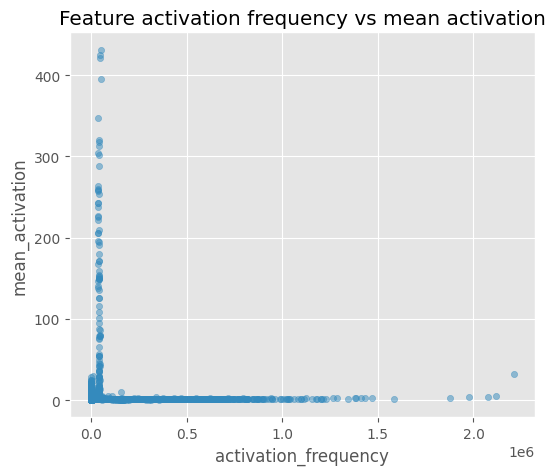

In [8]:
ax = df.plot.scatter(
    x="activation_frequency",
    y="mean_activation",
    alpha=0.5,
    figsize=(6, 5),
    title="Feature activation frequency vs mean activation",
)
ax.set_xlabel("activation_frequency")
ax.set_ylabel("mean_activation")
plt.show()

In [9]:
def token_counts(feature_id, top_k=15):
    row = df.loc[df["feature"] == feature_id]
    if row.empty:
        raise ValueError(f"Feature {feature_id} not found")
    tokens = []
    for ex in row.iloc[0]["top_examples"]:
        tok = ex.get("token", "")
        if tok is None:
            continue
        tokens.append(tok.strip() or tok)
    counts = Counter(tokens)
    return pd.Series(counts).sort_values(ascending=False).head(top_k)


def show_feature(feature_id, n_examples=8):
    row = df.loc[df["feature"] == feature_id]
    if row.empty:
        print(f"Feature {feature_id} not found")
        return

    examples = sorted(
        row.iloc[0]["top_examples"],
        key=lambda ex: ex.get("activation", 0),
        reverse=True,
    )
    for ex in examples[:n_examples]:
        token = ex.get("token", "")
        ctx = ex.get("context", "")
        activation = ex.get("activation")
        pos = ex.get("position")
        text_idx = ex.get("text_idx")
        needle = token.strip()
        if needle and needle in ctx:
            highlighted = ctx.replace(needle, f"[{needle}]", 1)
        else:
            highlighted = ctx
        print(
            f"feature={feature_id} activation={activation:.3f} pos={pos} text_idx={text_idx} token={repr(token)}"
        )
        print(highlighted)
        print()


def plot_positions(feature_id, bins=20):
    row = df.loc[df["feature"] == feature_id]
    if row.empty:
        print(f"Feature {feature_id} not found")
        return
    positions = [ex.get("position") for ex in row.iloc[0]["top_examples"] if ex.get("position") is not None]
    if not positions:
        print("No position info available")
        return
    plt.figure(figsize=(6, 4))
    plt.hist(positions, bins=bins, color="#4472c4", alpha=0.8)
    plt.title(f"Position histogram for feature {feature_id}")
    plt.xlabel("token position (within sequence)")
    plt.ylabel("count")
    plt.show()

In [10]:
df.loc[df['feature'] == 14]

,feature,activation_frequency,mean_activation,top_examples,num_examples
11,14,1.000,0.520,"[{'token': ' with', 'activation': 0.5196403861...",1


In [11]:
# Example feature to inspect; change this as you explore
feature_id = 14
print("Token counts:")
display(token_counts(feature_id))
print("Top contexts:")
show_feature(feature_id, n_examples=6)
# plot_positions(feature_id)

Token counts:


with    1
dtype: int64

Top contexts:
feature=14 activation=0.520 pos=6 text_idx=394 token=' with'
#  Compar ing  Distance  Tr aveled  [with]  Dis placement :  A  Subway  Train



In [12]:
# Grab some low-frequency but high-activation features to interpret first
specific = df.sort_values(by=["activation_frequency", "mean_activation"], ascending=[True, False]).head(15)
display(specific[["feature", "activation_frequency", "mean_activation", "num_examples"]])

,feature,activation_frequency,mean_activation,num_examples
1547,1845,1.000,9.245,1
54,67,1.000,7.671,1
1560,1860,1.000,7.578,1
2224,2643,1.000,6.878,1
2733,3234,1.000,6.672,1
1212,1455,1.000,6.623,1
1739,2065,1.000,6.436,1
3331,3936,1.000,4.798,1
1631,1943,1.000,4.154,1
3026,3572,1.000,4.150,1


In [13]:
# "Proportion" feature
feature_id = 3593
print("Token counts:")
display(token_counts(feature_id))
print("Top contexts:")
show_feature(feature_id, n_examples=6)
# plot_positions(feature_id)

Token counts:


proportion      12
to               3
greater          3
subdiv           2
Dion             1
substant         1
she              1
alum             1
differential     1
dtype: int64

Top contexts:
feature=3593 activation=15.904 pos=70 text_idx=22586 token=' to'
 of  oil  wells  and  as  pickle  liquor —an  acid  used  [to]  remove  oxide  coating  from  iron  or  steel  that  is  to  be  gal vanized ,  t inned ,  or  en ame led .  The  amounts  of  hydro b rom ic  acid

feature=3593 activation=15.513 pos=107 text_idx=19244 token=' proportion'
 at  the  corresponding  higher  ambient  pressure ,  and  the  concentrations  of  the  gases  dissolved  in  the  diver ’s  blood  are  [proportion] ally  higher  per  Henry ’s  law .

feature=3593 activation=15.440 pos=193 text_idx=30755 token=' Dion'
;  credit  b :  modification  of  work  by  Roberto  Ver zo ;  credit  c :  modification  of  work  by  Eric  [Dion] ;  credit  d :  modification  of  work  by  Valerie  Ly kes )

feature=3593 activation=15.427 pos=52 text_idx=753 token=' proportion'
 widely  separated  points  on  the  straight  line .  This  is  because  any  error  in  reading  data  from  the  graph  is  [

In [14]:
# "Of" feature
feature_id = 1726
print("Token counts:")
display(token_counts(feature_id))
print("Top contexts:")
show_feature(feature_id, n_examples=6)
# plot_positions(feature_id)

Token counts:


of    25
dtype: int64

Top contexts:
feature=1726 activation=16.976 pos=63 text_idx=25806 token=' of'
 possible  frequencies  [of]  radiation  ( Figure   8 . 1 1 ).  The  difference  between  wavelengths  relates  to  the  amount  of  energy  carried  by  them .   
 FIG URE   8 . 1 1  The  sun  emits  energy  in  the  form

feature=1726 activation=16.656 pos=873 text_idx=13383 token=' of'
radio active  dating  an  application  [of]  radioactive  decay  in  which  the  age  of  a  material  is  determined  by  the  amount  of  radio activity  of  a  particular  type  that  occurs    
 radio activity  the  emission  of  rays  from  the  nuclei  of  atoms

feature=1726 activation=16.592 pos=84 text_idx=13393 token=' of'
 applications  [of]  radioactive  decay  is  radioactive  dating ,  in  which  the  age  of  a  material  is  determined  by  the  amount  of  radioactive  decay  that  occurs .  The  rate  of  decay  is  called  the  activity    :    The  SI  unit  for

feature=1726 activation=16.553 pos=20 tex

In [15]:
feature_id = 3750
print("Token counts:")
display(token_counts(feature_id))
print("Top contexts:")
show_feature(feature_id, n_examples=6)
# plot_positions(feature_id)

Token counts:


hap            3
None           2
CTL            2
composition    1
environment    1
Transparent    1
vascular       1
Protection     1
-linked        1
Gener          1
overall        1
decay          1
scientific     1
species        1
entropy        1
dtype: int64

Top contexts:
feature=3750 activation=737.607 pos=0 text_idx=23901 token='decay'
[decay]  rate    with    the  decay  constant  for  the  particular  radio is otope

feature=3750 activation=727.801 pos=0 text_idx=24338 token='scientific'
[scientific]  papers  published  in  scientific  journals .  A  scientific  research  paper  consists  of  several  well defined  sections :  introduction ,  materials

feature=3750 activation=722.792 pos=0 text_idx=30871 token='ABA'
[ABA]  induces  dorm ancy  in  seeds  by  blocking  ger mination  and  promoting  the  synthesis  of  storage  proteins .  Plants  adapted  to

feature=3750 activation=718.801 pos=0 text_idx=34724 token='hab'
[hab] its  of  warm -blood ed  versus  cold -blood ed  animals .  Modeling  of  ecosystem  energy  is  best  done  with  ecological

feature=3750 activation=717.872 pos=0 text_idx=28847 token='sexual'
[sexual]  reproduction ,  and  is  in  many  ways  a  typical  e uk ary otic  nucleus ,  except  that  its  genes  are

In [16]:
# Weirdly almost identical to feature 3750 ^
feature_id = 528
print("Token counts:")
display(token_counts(feature_id))
print("Top contexts:")
show_feature(feature_id, n_examples=6)
# plot_positions(feature_id)

Token counts:


hap            3
CTL            2
None           2
decay          1
-linked        1
Transparent    1
environment    1
Protection     1
overall        1
composition    1
Gener          1
scientific     1
affer          1
entropy        1
species        1
dtype: int64

Top contexts:
feature=528 activation=690.204 pos=0 text_idx=23901 token='decay'
[decay]  rate    with    the  decay  constant  for  the  particular  radio is otope

feature=528 activation=679.986 pos=0 text_idx=24338 token='scientific'
[scientific]  papers  published  in  scientific  journals .  A  scientific  research  paper  consists  of  several  well defined  sections :  introduction ,  materials

feature=528 activation=675.892 pos=0 text_idx=30871 token='ABA'
[ABA]  induces  dorm ancy  in  seeds  by  blocking  ger mination  and  promoting  the  synthesis  of  storage  proteins .  Plants  adapted  to

feature=528 activation=673.825 pos=0 text_idx=34724 token='hab'
[hab] its  of  warm -blood ed  versus  cold -blood ed  animals .  Modeling  of  ecosystem  energy  is  best  done  with  ecological

feature=528 activation=671.179 pos=0 text_idx=28847 token='sexual'
[sexual]  reproduction ,  and  is  in  many  ways  a  typical  e uk ary otic  nucleus ,  except  that  its  genes  are

fea

In [17]:
# Weirdly almost identical to feature 3750 and 528^
feature_id = 3338
print("Token counts:")
display(token_counts(feature_id))
print("Top contexts:")
show_feature(feature_id, n_examples=6)
# plot_positions(feature_id)

Token counts:


hap            3
CTL            2
decay          1
scientific     1
cn             1
vascular       1
Transparent    1
environment    1
Protection     1
-linked        1
overall        1
composition    1
Gener          1
entropy        1
species        1
dtype: int64

Top contexts:
feature=3338 activation=662.067 pos=0 text_idx=23901 token='decay'
[decay]  rate    with    the  decay  constant  for  the  particular  radio is otope

feature=3338 activation=653.407 pos=0 text_idx=24338 token='scientific'
[scientific]  papers  published  in  scientific  journals .  A  scientific  research  paper  consists  of  several  well defined  sections :  introduction ,  materials

feature=3338 activation=647.790 pos=0 text_idx=30871 token='ABA'
[ABA]  induces  dorm ancy  in  seeds  by  blocking  ger mination  and  promoting  the  synthesis  of  storage  proteins .  Plants  adapted  to

feature=3338 activation=646.908 pos=0 text_idx=34724 token='hab'
[hab] its  of  warm -blood ed  versus  cold -blood ed  animals .  Modeling  of  ecosystem  energy  is  best  done  with  ecological

feature=3338 activation=645.181 pos=0 text_idx=28847 token='sexual'
[sexual]  reproduction ,  and  is  in  many  ways  a  typical  e uk ary otic  nucleus ,  except  that  its  genes  are

In [18]:
# Weirdly almost identical to feature 3750 and 528 and 3338^
feature_id = 179
print("Token counts:")
display(token_counts(feature_id))
print("Top contexts:")
show_feature(feature_id, n_examples=6)
# plot_positions(feature_id)

Token counts:


hap            3
None           2
CTL            2
decay          1
Gener          1
Transparent    1
environment    1
cn             1
Protection     1
overall        1
composition    1
scientific     1
entropy        1
species        1
affer          1
dtype: int64

Top contexts:
feature=179 activation=644.893 pos=0 text_idx=23901 token='decay'
[decay]  rate    with    the  decay  constant  for  the  particular  radio is otope

feature=179 activation=635.480 pos=0 text_idx=24338 token='scientific'
[scientific]  papers  published  in  scientific  journals .  A  scientific  research  paper  consists  of  several  well defined  sections :  introduction ,  materials

feature=179 activation=632.839 pos=0 text_idx=30871 token='ABA'
[ABA]  induces  dorm ancy  in  seeds  by  blocking  ger mination  and  promoting  the  synthesis  of  storage  proteins .  Plants  adapted  to

feature=179 activation=630.730 pos=0 text_idx=34724 token='hab'
[hab] its  of  warm -blood ed  versus  cold -blood ed  animals .  Modeling  of  ecosystem  energy  is  best  done  with  ecological

feature=179 activation=627.227 pos=0 text_idx=28847 token='sexual'
[sexual]  reproduction ,  and  is  in  many  ways  a  typical  e uk ary otic  nucleus ,  except  that  its  genes  are

fea

In [19]:
# Weirdly almost identical to feature 3750 and 528 and 3338^
feature_id = 769
print("Token counts:")
display(token_counts(feature_id))
print("Top contexts:")
show_feature(feature_id, n_examples=6)
# plot_positions(feature_id)

Token counts:


hap            3
CTL            2
None           2
decay          1
species        1
Transparent    1
aleur          1
Protection     1
-linked        1
composition    1
overall        1
scientific     1
Gener          1
affer          1
entropy        1
dtype: int64

Top contexts:
feature=769 activation=405.899 pos=0 text_idx=23901 token='decay'
[decay]  rate    with    the  decay  constant  for  the  particular  radio is otope

feature=769 activation=400.864 pos=0 text_idx=24338 token='scientific'
[scientific]  papers  published  in  scientific  journals .  A  scientific  research  paper  consists  of  several  well defined  sections :  introduction ,  materials

feature=769 activation=396.736 pos=0 text_idx=30871 token='ABA'
[ABA]  induces  dorm ancy  in  seeds  by  blocking  ger mination  and  promoting  the  synthesis  of  storage  proteins .  Plants  adapted  to

feature=769 activation=395.728 pos=0 text_idx=34724 token='hab'
[hab] its  of  warm -blood ed  versus  cold -blood ed  animals .  Modeling  of  ecosystem  energy  is  best  done  with  ecological

feature=769 activation=395.420 pos=0 text_idx=28847 token='sexual'
[sexual]  reproduction ,  and  is  in  many  ways  a  typical  e uk ary otic  nucleus ,  except  that  its  genes  are

fea

In [70]:
# "aromatic" token
feature_id = 1597
print("Token counts:")
display(token_counts(feature_id))
print("Top contexts:")
show_feature(feature_id, n_examples=10)
# plot_positions(feature_id)

Token counts:


aromatic    9
typ         5
inhab       5
dispers     3
Bras        1
brass       1
relaxing    1
dtype: int64

Top contexts:
feature=1597 activation=11.735 pos=106 text_idx=28611 token=' aromatic'
 the  non volatile  components  in  oil  can  be  degraded  within  one  year  of  the  spill .  Other  oil  fractions  containing  [aromatic]  and  highly  bran ched  hydro carbon  chains  are  more  difficult  to  remove  and  remain  in  the  environment  for  longer  periods

feature=1597 activation=11.557 pos=68 text_idx=24541 token=' aromatic'
 in  the  examples  of  cyc lop ent ane  and  cyc lo hex ane .  Another  type  of  hydro carbon ,  [aromatic]  hydro car bons ,  consists  of  closed  rings  of  carbon  atoms  with  alternating  single  and  double  bonds .  We  find

feature=1597 activation=11.437 pos=263 text_idx=28788 token='typ'
tos keleton ,  and  the  end os ymb iotic  org anel les — may  have  diver ged  from  the  " [typ] ical "  pattern .   
 FIG URE   2 3 . 9  E uk ary otic  super groups .  This

feature=1597 activation=11.203 pos=20 text_idx=23544 token=' aromatic'
B enz ene , 

In [81]:
# "infinit" token
feature_id = 407
print("Token counts:")
display(token_counts(feature_id))
print("Top contexts:")
show_feature(feature_id, n_examples=25)
# plot_positions(feature_id)

Token counts:


infinit    14
Diff        4
Gen         3
reflex      2
agen        1
mil         1
dtype: int64

Top contexts:
feature=407 activation=12.250 pos=76 text_idx=7689 token=' infinit'
 arrows  with  each  arrow  representing  the  force  on  a  test  charge    .  Field  lines  are  essentially  a  map  of  [infinit] esimal  force  vectors .

feature=407 activation=11.926 pos=563 text_idx=27674 token='agen'
 an  organism 's  genetic  makeup    
 met abol omics  study  of  small  molecule  metabol ites  in  an  organism    
 met [agen] omics  study  of  multiple  species '  collective  genomes  that  grow  and  interact  in  an  environmental  niche    
 micro sat ellite

feature=407 activation=11.841 pos=89 text_idx=23284 token=' infinit'
val ent  bonding  between  lig ands  and  metal  ions .  Both  the  lig and  and  the  metal  are  treated  as  [infinit] es im ally  small  point  charges .

feature=407 activation=11.838 pos=44 text_idx=1590 token=' infinit'
 approaches  zero .  Even  the  relatively  small  weight  of  any  flexible  connector  will  cause  it  to  sag ,  since  an 

In [69]:
# "for" token
feature_id = 3949
print("Token counts:")
display(token_counts(feature_id))
print("Top contexts:")
show_feature(feature_id, n_examples=6)
# plot_positions(feature_id)

Token counts:


for          12
preparing     3
intra         2
irregular     2
destruct      2
til           1
-for          1
ready         1
prepar        1
dtype: int64

Top contexts:
feature=3949 activation=11.884 pos=27 text_idx=4811 token=' for'
 the  example  shows  that  speed  is  invers ely  proportional  to  the  square  of  the  radius  of  the  tube ,  making  [for]  large  effects  when  radius  varies .  We  can  blow  out  a  candle  at  quite  a  distance ,  for  example ,

feature=3949 activation=11.745 pos=25 text_idx=13437 token=' for'
 charge ,  electron  family  number ,  and  the  total  number  of  nucle ons  are  all  cons erved  by  the  rule  [for]  electron  capture  given  in  the  equation    .  To  do  this ,  identify  the  values  of  each  before  and  after

feature=3949 activation=11.606 pos=79 text_idx=34652 token=' til'
 because  of  their  high  mercury  content .  These  individuals  are  advised  to  eat  fish  low  in  mercury :  salmon ,  [til] apia ,  shrimp ,  pol lock ,  and  cat fish .  Biom agn ification  is  a  good  example  of  how

feature=3949 activation=11.518 pos=25 text_idx=13434 token=' for'
 charge

## Token-density interpretability heuristic

Classify features by how concentrated their token triggers are. High top-1 share → "interpretable"; high top-3 share → "medium"; flatter distributions → "polysemantic". Thresholds are adjustable below.

In [23]:
df.loc[df['feature'] == 140]

,feature,activation_frequency,mean_activation,top_examples,num_examples
120,140,"7,834.000",2.411,"[{'token': ' Internal', 'activation': 16.22704...",25


In [24]:
type(df.loc[df['feature'] == 140]['top_examples'])

pandas.core.series.Series

In [25]:
df.loc[df['feature'] == 140]['top_examples'].get("token", "")

''

In [26]:
df.loc[df['feature'] == 140]['top_examples'].keys()

Index([120], dtype='int64')

In [27]:
import math

# Heuristic: how concentrated are the tokens that trigger a feature?
def feature_token_density(row, top1_thresh=0.9, top3_thresh=0.9):
    tokens = []
    for ex in row["top_examples"]:
        tok = ex.get("token", "")
        if tok is None:
            continue
        tokens.append(tok.strip() or tok)
    counts = Counter(tokens)
    total = sum(counts.values())
    if total == 0:
        return {
            "top1_share": 0.0,
            "top3_share": 0.0,
            "entropy": None,
            "entropy_norm": None,
            "label": "no_examples",
        }
    mc = counts.most_common()
    top1_share = mc[0][1] / total
    top3_share = sum(c for _, c in mc[:3]) / total

    if top1_share >= top1_thresh:
        label = "interpretable"
    elif top3_share >= top3_thresh:
        label = "medium"
    else:
        label = "polysemantic"
    return {
        "top1_share": top1_share,
        "top3_share": top3_share,
        "label": label,
    }


In [28]:
density_rows = []
for _, row in df.iterrows():
    stats = feature_token_density(row)
    stats["feature"] = row["feature"]
    stats["num_examples"] = row["num_examples"]
    density_rows.append(stats)

density_df = pd.DataFrame(density_rows)
df_density = df.merge(density_df, on=["feature", "num_examples"], how="left")

min_examples = 10
df_density = df_density[df_density["num_examples"] >= min_examples]

print("Label counts:")
display(df_density["label"].value_counts())

print("INTERPRETABLE features (top1_share >= 90%)")
display(df_density[df_density["label"] == "interpretable"]
        .sort_values("top1_share", ascending=False)
        .head(8)[["feature", "top1_share", "top3_share", "num_examples"]])

print("MEDIUM features (top3_share >= 90%, but top1 < 90%)")
display(df_density[df_density["label"] == "medium"]
        .sort_values("top3_share", ascending=False)
        .head(8)[["feature", "top1_share", "top3_share", "num_examples"]])

print("POLYSEMANTIC features (top3_share < 90%)")
display(df_density[df_density["label"] == "polysemantic"]
        .sort_values("top3_share", ascending=False)
        .head(8)[["feature", "top1_share", "top3_share", "num_examples"]])

Label counts:


label
polysemantic     1235
interpretable     902
medium            589
Name: count, dtype: int64

INTERPRETABLE features (top1_share >= 90%)


,feature,top1_share,top3_share,num_examples
2,2,1.000,1.000,11
2571,3043,1.000,1.000,25
2234,2653,1.000,1.000,25
2235,2654,1.000,1.000,25
2239,2658,1.000,1.000,25
2240,2659,1.000,1.000,25
2245,2665,1.000,1.000,25
2246,2666,1.000,1.000,25


MEDIUM features (top3_share >= 90%, but top1 < 90%)


,feature,top1_share,top3_share,num_examples
5,6,0.760,1.000,25
1847,2193,0.640,1.000,25
1946,2318,0.840,1.000,25
1928,2294,0.760,1.000,25
1922,2286,0.880,1.000,25
1907,2263,0.640,1.000,25
1904,2258,0.880,1.000,25
1902,2254,0.840,1.000,25


POLYSEMANTIC features (top3_share < 90%)


,feature,top1_share,top3_share,num_examples
1360,1628,0.526,0.895,19
1554,1854,0.667,0.889,18
1606,1913,0.722,0.889,18
170,197,0.440,0.880,25
2935,3466,0.720,0.880,25
783,933,0.600,0.880,25
2920,3449,0.560,0.880,25
398,471,0.480,0.880,25


In [82]:
feature_id = 2254
print("Token counts:")
display(token_counts(feature_id))
print("Top contexts:")
show_feature(feature_id, n_examples=25)

Token counts:


vector     21
vectors     3
Vector      1
dtype: int64

Top contexts:
feature=2254 activation=13.823 pos=4 text_idx=4123 token=' vector'
Angular  momentum  is  a  [vector]  and ,  therefore ,  has  direction  as  well  as  magnitude .  Tor que  affects  both  the  direction  and  the  magnitude

feature=2254 activation=13.776 pos=40 text_idx=4026 token=' vector'
 acceleration  and  imp arts  rotational  kinetic  energy  to  it  by  exert ing  a  torque  about  the  knee .  is  a  [vector]  that  is  perpendicular  to    .  This  example  examines  the  situation .

feature=2254 activation=13.764 pos=64 text_idx=1436 token=' vector'
 falling  object  is  the grav itational  force ,  commonly  called  its  weight  .  Weight  can  be  den oted  as  a  [vector]  because  it  has  a  direction ;  virt  den oted  as    .  Gal ileo  was  instrumental  in  showing  that ,

feature=2254 activation=13.384 pos=35 text_idx=1734 token=' vector'
Force  is  a  push  or  pull  that  can  be  defined  in  terms  of  various  standards ,  and  it  is  a  [ve

In [30]:
feature_id = 2263
print("Token counts:")
display(token_counts(feature_id))
print("Top contexts:")
show_feature(feature_id, n_examples=6)

Token counts:


lymph    16
ymph      9
dtype: int64

Top contexts:
feature=2263 activation=12.560 pos=17 text_idx=28679 token=' lymph'
2 4 .  A  person  in  England  arrives  at  a  medical  clinic  with  a  fever  and  swollen  [lymph]  nodes  shortly  after  returning  from  a  visit  to  New  Mexico .  For  which  bacteria  should  the  doctor  test  the  patient

feature=2263 activation=11.250 pos=134 text_idx=33177 token='ymph'
 fluid  passes  through  l[ymph]  nodes  before  it  returns  to  the  heart  via  the  superior  v ena  c ava .  L ymph  nodes  are  specialized  organs  that  filter  the  lymph  by  per col ation  through  a  maze  of  connect ive  tissue  filled

feature=2263 activation=11.185 pos=40 text_idx=33512 token='ymph'
 l[ymph]  throughout  the  body .  The  liquid  enters  ( b )  lymph  nodes  through  a ffer ent  vessels .  L ymph  nodes  are  filled  with  lymph ocytes  that  purge  infect ing  cells .  The  lymph  then  exits  through  e ffer ent

feature=2263 activation=11.005 pos=104 text_idx=28557 token=' 

In [31]:
feature_id = 2294
print("Token counts:")
display(token_counts(feature_id))
print("Top contexts:")
show_feature(feature_id, n_examples=6)

Token counts:


form     19
forms     6
dtype: int64

Top contexts:
feature=2294 activation=7.783 pos=54 text_idx=26897 token=' form'
. 1 1 ).  At  the  most  basic  level ,  DNA  is  wrapped  around  proteins  known  as  hist ones  to  [form]  structures  called  nucle osomes .  The  hist ones  are  evolution arily  cons erved  proteins  that  are  rich  in  basic  amino

feature=2294 activation=7.742 pos=58 text_idx=26060 token=' forms'
mits  signals  within  a  cell  intr acellular  signaling  communication  within  cells  ion  channel -linked  receptor  cell -s urface  receptor  that  [forms]  a  plasma  membrane  channel ,  which  opens  when  a  lig and  binds  to  the  extr acellular  domain  ( lig and

feature=2294 activation=7.575 pos=49 text_idx=24503 token=' form'
 process  of  dissoci ation .  Diss oci ation  occurs  when  atoms  or  groups  of  atoms  break  off  from  molecules  and  [form]  ions .  Consider  table  salt  ( Na Cl ,  or  sodium  chloride ):  when  we  add  Na Cl  crystals  to

feature=2294 activation=7.524 po

In [32]:
feature_id = 2318
print("Token counts:")
display(token_counts(feature_id))
print("Top contexts:")
show_feature(feature_id, n_examples=6)

Token counts:


glucose    21
sugar       4
dtype: int64

Top contexts:
feature=2318 activation=13.398 pos=11 text_idx=26119 token=' sugar'
2 7 .  Ins ulin  is  a  hormone  that  regulates  blood  [sugar]  by  binding  to  its  receptor ,  insulin  receptor  ty ros ine  kinase .  How  does  insulin ’s  behavior  differ  from

feature=2318 activation=12.278 pos=54 text_idx=24706 token=' glucose'
 development ,  metabolism ,  and  reproduction .  For  example ,  insulin  is  a  protein  hormone  that  helps  regulate  the  blood  [glucose]  level .  Table   3 . 1  lists  the  primary  types  and  functions  of  proteins .

feature=2318 activation=12.017 pos=91 text_idx=24649 token=' sugar'
 and  prevent  diseases .  For  example ,  diet it ians  may  teach  a  patient  with  diabetes  how  to  manage  blood  [sugar]  levels  by  eating  the  correct  types  and  amounts  of  carbohydrates .  Diet it ians  may  also  work  in  nursing  homes

feature=2318 activation=11.790 pos=13 text_idx=32512 token=' glucose'
Ins ulin  is  produced  by  the  p

In [33]:
# Check for missing feature IDs relative to expected 4096
expected = set(range(4096))
have = set(df["feature"])
missing = sorted(expected - have)
print(f"Missing {len(missing)} / 4096 features in the JSONL")
print("First few missing:", missing[:20])


Missing 632 / 4096 features in the JSONL
First few missing: [5, 7, 12, 17, 20, 31, 32, 33, 36, 40, 41, 46, 48, 84, 86, 106, 109, 116, 118, 137]


## Matrix heatmaps

Quick loaders and heatmaps for the saved matrices in `.../matrices` (co-occurrence and similarity). Truncates to a manageable top-left block by default to keep plots readable.

In [34]:
matrices_dir = repo_root / "Qwen_Qwen3-0.6B.blocks.9.hook_resid_post.btop128sae.all_science.exp4.analysis/matrices"
mat_paths = {
    "cooccurrence": matrices_dir / "feature_cooccurrence_20251213_151033.npy",
    "similarity": matrices_dir / "feature_similarity_20251213_151033.npy",
}

print("Matrix paths:")
for name, path in mat_paths.items():
    print(f"  {name}: {path}")

Matrix paths:
  cooccurrence: /Users/deancasey/Documents/Columbia/CRIS Lab/SAELens/Qwen_Qwen3-0.6B.blocks.9.hook_resid_post.btop128sae.all_science.exp4.analysis/matrices/feature_cooccurrence_20251213_151033.npy
  similarity: /Users/deancasey/Documents/Columbia/CRIS Lab/SAELens/Qwen_Qwen3-0.6B.blocks.9.hook_resid_post.btop128sae.all_science.exp4.analysis/matrices/feature_similarity_20251213_151033.npy


In [35]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform
import numpy as np

def plot_cooccurrence_for_paper(mat, title, max_features=1000, method='correlation'):
    """Publication-quality cooccurrence visualization with clustering."""
    
    # For large matrices, sample or use full if small enough
    if mat.shape[0] > max_features:
        # Sample top features by variance in cooccurrence
        feature_variance = np.var(mat, axis=1)
        top_idx = np.argsort(feature_variance)[-max_features:]
        mat_sub = mat[np.ix_(top_idx, top_idx)]
    else:
        mat_sub = mat
        top_idx = np.arange(len(mat))
    
    # Hierarchical clustering to reorder
    if method == 'correlation':
        # Convert correlation to distance
        dist = 1 - np.abs(mat_sub)
        dist = np.clip(dist, 0, 2)  # handle numerical issues
    else:
        dist = 1 - mat_sub
    
    # Cluster and reorder
    linkage_matrix = linkage(squareform(dist, checks=False), method='average')
    dendro = dendrogram(linkage_matrix, no_plot=True)
    reorder_idx = dendro['leaves']
    mat_ordered = mat_sub[np.ix_(reorder_idx, reorder_idx)]
    
    # Plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), 
                                     gridspec_kw={'width_ratios': [1, 20]})
    
    # Dendrogram
    dendrogram(linkage_matrix, ax=ax1, orientation='left')
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)  # FIXED: square brackets
    ax1.spines['bottom'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    
    # Heatmap with appropriate colormap
    if method == 'correlation':
        vmax = np.abs(mat_ordered).max()
        im = ax2.imshow(mat_ordered, cmap='RdBu_r', aspect='auto',
                       vmin=-vmax, vmax=vmax, interpolation='nearest')
    else:
        im = ax2.imshow(mat_ordered, cmap='viridis', aspect='auto',
                       interpolation='nearest')
    
    plt.colorbar(im, ax=ax2, label=method)
    ax2.set_xlabel('Feature index (clustered)')
    ax2.set_ylabel('Feature index (clustered)')
    ax2.set_title(title)
    
    plt.tight_layout()
    return fig, top_idx[reorder_idx]


def plot_similarity_vs_cooccurrence(similarity, cooccurrence, sample_size=10000):
    """Show relationship between similarity and cooccurrence."""
    # Sample off-diagonal elements
    n = similarity.shape[0]
    idx = np.triu_indices(n, k=1)
    
    if len(idx[0]) > sample_size:
        sample_idx = np.random.choice(len(idx[0]), sample_size, replace=False)
        i, j = idx[0][sample_idx], idx[1][sample_idx]
    else:
        i, j = idx
    
    sim_vals = similarity[i, j]
    cooc_vals = cooccurrence[i, j]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Scatter plot
    ax1.hexbin(sim_vals, cooc_vals, gridsize=50, cmap='viridis', mincnt=1)
    ax1.set_xlabel('Decoder Similarity (cosine)')
    ax1.set_ylabel('Feature Cooccurrence (correlation)')
    ax1.set_title('Similarity vs Cooccurrence')
    ax1.grid(True, alpha=0.3)
    
    # Distribution comparison
    ax2.hist(sim_vals, bins=50, alpha=0.5, label='Similarity', density=True)
    ax2.hist(cooc_vals, bins=50, alpha=0.5, label='Cooccurrence', density=True)
    ax2.set_xlabel('Value')
    ax2.set_ylabel('Density')
    ax2.legend()
    ax2.set_title('Value Distributions')
    
    plt.tight_layout()
    return fig


def plot_high_value_clusters(mat, title, n_clusters=5, max_dim=100):
    """Identify and visualize top clusters of high cooccurrence."""
    from sklearn.cluster import SpectralClustering
    
    # Find features with highest overall cooccurrence
    row_sums = np.abs(mat).sum(axis=1)
    top_features = np.argsort(row_sums)[-max_dim*2:]
    
    mat_sub = mat[np.ix_(top_features, top_features)]
    
    # Cluster
    clustering = SpectralClustering(n_clusters=n_clusters, 
                                    affinity='precomputed',
                                    assign_labels='discretize')
    # Convert to affinity
    affinity = (mat_sub + 1) / 2  # shift to [0, 1]
    labels = clustering.fit_predict(affinity)
    
    # Sort by cluster
    sort_idx = np.argsort(labels)
    mat_sorted = mat_sub[np.ix_(sort_idx, sort_idx)]
    labels_sorted = labels[sort_idx]
    
    fig, ax = plt.subplots(figsize=(10, 9))
    im = ax.imshow(mat_sorted, cmap='RdBu_r', aspect='auto',
                   vmin=-1, vmax=1)
    
    # Add cluster boundaries
    boundaries = np.where(np.diff(labels_sorted))[0] + 0.5
    for b in boundaries:
        ax.axhline(b, color='black', linewidth=2)
        ax.axvline(b, color='black', linewidth=2)
    
    plt.colorbar(im, ax=ax)
    ax.set_title(f'{title}\n{n_clusters} clusters identified')
    ax.set_xlabel('Feature index')
    ax.set_ylabel('Feature index')
    
    return fig, top_features[sort_idx], labels_sorted

In [36]:
cooccurrence_matrix = np.load(mat_paths["cooccurrence"])
similarity_matrix = np.load(mat_paths["similarity"])

plot_dir = "SAELens/Qwen_Qwen3-0.6B.blocks.9.hook_resid_post.btop128sae.all_science.exp4.analysis/plots"
os.makedirs(plot_dir, exist_ok=True)

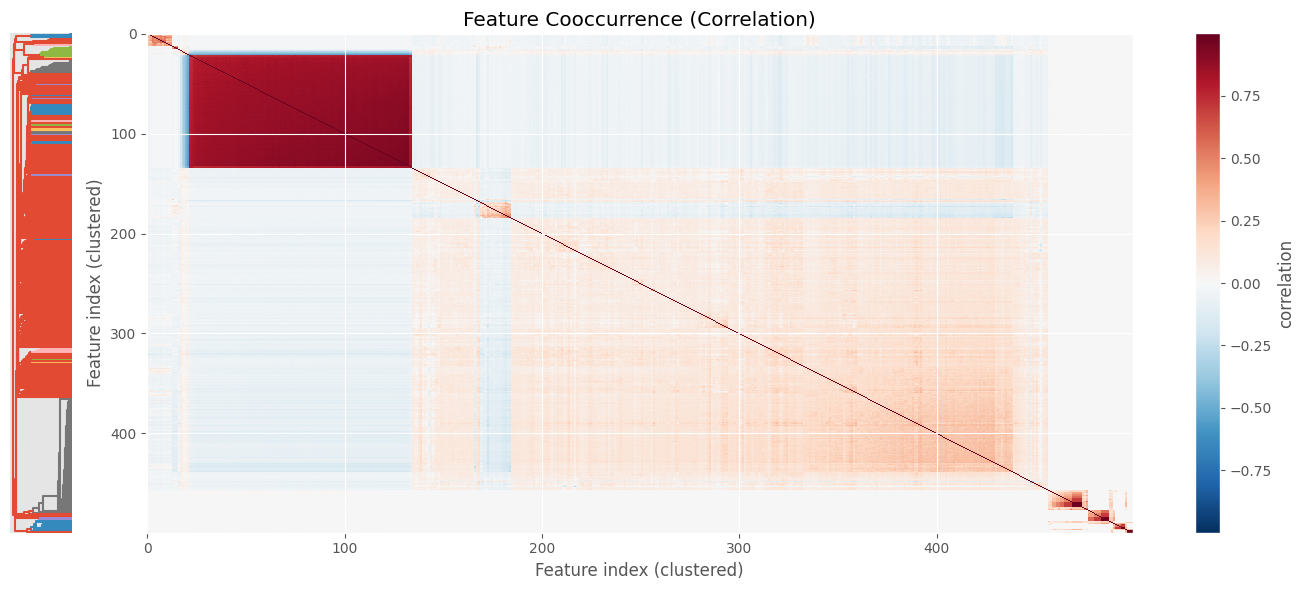

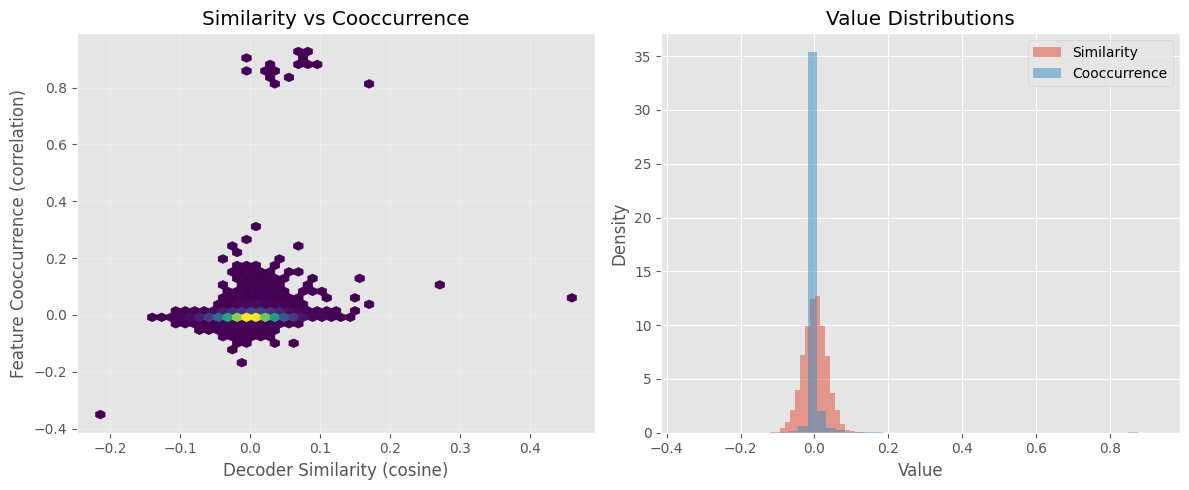

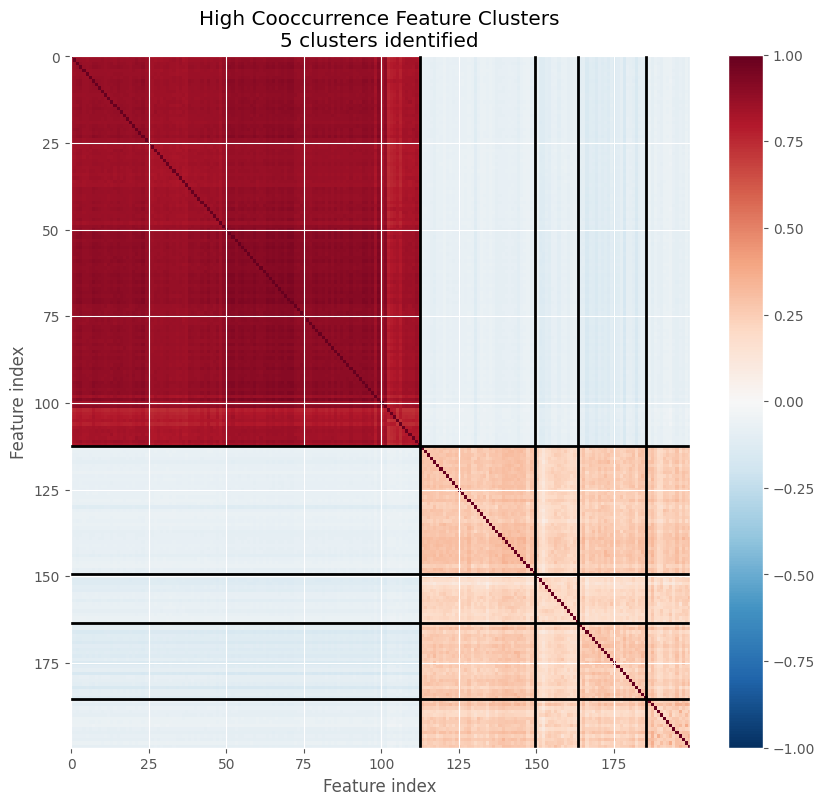

In [45]:
# Figure 1: Clustered overview
fig1, ordered_idx = plot_cooccurrence_for_paper(
    cooccurrence_matrix, 
    'Feature Cooccurrence (Correlation)',
    max_features=500
)
# Figure 2: Similarity vs Cooccurrence relationship
fig2 = plot_similarity_vs_cooccurrence(similarity_matrix, cooccurrence_matrix)

# Figure 3: High cooccurrence clusters
fig3, cluster_features, labels = plot_high_value_clusters(
    cooccurrence_matrix,
    'High Cooccurrence Feature Clusters'
)

In [38]:
from pathlib import Path

plot_dir = Path("../Qwen_Qwen3-0.6B.blocks.9.hook_resid_post.btop128sae.all_science.exp4.analysis/plots")

fig1.savefig(plot_dir / 'feature_cooccurrence_clustered.pdf', dpi=300, bbox_inches='tight')
fig2.savefig(plot_dir / 'similarity_vs_cooccurrence.pdf', dpi=300, bbox_inches='tight')
fig3.savefig(plot_dir / 'cooccurrence_clusters.pdf', dpi=300, bbox_inches='tight')

In [39]:
cluster_features = list(range(15, 130))
sim_cluster = similarity_matrix[np.ix_(cluster_features, cluster_features)]
print(f"Mean similarity in cluster: {sim_cluster.mean():.3f}")
print(f"Mean similarity overall: {similarity_matrix.mean():.3f}")

Mean similarity in cluster: 0.010
Mean similarity overall: 0.001


In [61]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr, pearsonr 
from sklearn.decomposition import PCA
from matplotlib.patches import Patch

# ============================================================================
# UPDATED FUNCTIONS TO ACCEPT LIST OF CLUSTER FEATURES
# ============================================================================

def analyze_dominant_cluster(cooccurrence_matrix, similarity_matrix, 
                             cluster_features, save_dir=None):
    """Deep dive into the dominant co-occurring cluster."""
    
    cluster_features = np.array(cluster_features)  # Ensure it's an array
    n_features = cooccurrence_matrix.shape[0]
    
    # Extract cluster submatrices
    cooc_cluster = cooccurrence_matrix[np.ix_(cluster_features, cluster_features)]
    sim_cluster = similarity_matrix[np.ix_(cluster_features, cluster_features)]
    
    # Compare to overall statistics
    non_cluster = [i for i in range(n_features) if i not in cluster_features]
    if len(non_cluster) > 200:
        non_cluster = np.random.choice(non_cluster, 200, replace=False)
    cooc_non_cluster = cooccurrence_matrix[np.ix_(non_cluster, non_cluster)]
    sim_non_cluster = similarity_matrix[np.ix_(non_cluster, non_cluster)]
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # 1. Cooccurrence distribution
    ax = axes[0, 0]
    ax.hist(cooc_cluster.ravel(), bins=50, alpha=0.6, label='Cluster', density=True)
    ax.hist(cooc_non_cluster.ravel(), bins=50, alpha=0.6, label='Non-cluster', density=True)
    ax.set_xlabel('Cooccurrence')
    ax.set_ylabel('Density')
    ax.set_title('Cooccurrence Distribution')
    ax.legend()
    ax.axvline(0, color='black', linestyle='--', alpha=0.3)
    
    # 2. Similarity distribution
    ax = axes[0, 1]
    ax.hist(sim_cluster.ravel(), bins=50, alpha=0.6, label='Cluster', density=True)
    ax.hist(sim_non_cluster.ravel(), bins=50, alpha=0.6, label='Non-cluster', density=True)
    ax.set_xlabel('Decoder Similarity')
    ax.set_ylabel('Density')
    ax.set_title('Decoder Similarity Distribution')
    ax.legend()
    ax.axvline(0, color='black', linestyle='--', alpha=0.3)
    
    # 3. Similarity vs Cooccurrence (cluster vs non-cluster comparison)
    ax = axes[0, 2]

    # Sample from cluster
    n_sample_cluster = min(5000, len(cooc_cluster.ravel()))
    idx_cluster = np.random.choice(len(cooc_cluster.ravel()), n_sample_cluster, replace=False)

    # Sample from non-cluster
    n_sample_non = min(5000, len(cooc_non_cluster.ravel()))
    idx_non = np.random.choice(len(cooc_non_cluster.ravel()), n_sample_non, replace=False)

    # Plot non-cluster first (background)
    ax.scatter(sim_non_cluster.ravel()[idx_non], cooc_non_cluster.ravel()[idx_non], 
              alpha=0.2, s=5, c='blue', label='Non-cluster')

    # Plot cluster on top (foreground)
    ax.scatter(sim_cluster.ravel()[idx_cluster], cooc_cluster.ravel()[idx_cluster], 
              alpha=0.4, s=10, c='red', label='Cluster')

    ax.set_xlabel('Decoder Similarity')
    ax.set_ylabel('Cooccurrence')
    ax.set_title('Similarity vs Cooccurrence: Cluster vs Non-cluster')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Add correlation stats for both
    corr_cluster, pval_cluster = pearsonr(sim_cluster.ravel(), cooc_cluster.ravel())
    corr_non, pval_non = pearsonr(sim_non_cluster.ravel(), cooc_non_cluster.ravel())

    stats_text = f'Cluster: r={corr_cluster:.3f}\nNon-cluster: r={corr_non:.3f}'
    ax.text(0.95, 0.05, stats_text, 
       transform=ax.transAxes, va='bottom', ha='right', 
       bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
       fontsize=9)
    
    # 4. Row-wise statistics
    ax = axes[1, 0]
    cluster_row_means = cooc_cluster.mean(axis=1)
    cluster_row_stds = cooc_cluster.std(axis=1)
    ax.scatter(cluster_row_means, cluster_row_stds, alpha=0.6)
    ax.set_xlabel('Mean Cooccurrence')
    ax.set_ylabel('Std Cooccurrence')
    ax.set_title('Feature-wise Cooccurrence Stats (Cluster)')
    
    # 5. Heatmap of top co-occurring pairs in cluster
    ax = axes[1, 1]
    top_k = 30
    top_cooc_idx = np.argsort(cooc_cluster.ravel())[-top_k*top_k:]
    rows, cols = np.unravel_index(top_cooc_idx, cooc_cluster.shape)
    mask = rows != cols
    rows, cols = rows[mask][:top_k], cols[mask][:top_k]
    
    mini_cooc = cooc_cluster[np.ix_(rows, cols)]
    sns.heatmap(mini_cooc, cmap='RdBu_r', center=0, ax=ax, cbar_kws={'label': 'Cooccurrence'})
    ax.set_title(f'Top {top_k} Co-occurring Pairs')
    ax.set_xlabel('Feature (relative to cluster)')
    ax.set_ylabel('Feature (relative to cluster)')
    
    # 6. Summary statistics
    ax = axes[1, 2]
    ax.axis('off')
    
    stats_text = f"""
    CLUSTER ANALYSIS ({len(cluster_features)} features)
    Feature IDs: {cluster_features.min()}-{cluster_features.max()}
    
    Cooccurrence:
      Cluster mean: {cooc_cluster.mean():.4f}
      Non-cluster mean: {cooc_non_cluster.mean():.4f}
      Cluster std: {cooc_cluster.std():.4f}
      
    Decoder Similarity:
      Cluster mean: {sim_cluster.mean():.4f}
      Non-cluster mean: {sim_non_cluster.mean():.4f}
      Cluster std: {sim_cluster.std():.4f}
      
    Correlation:
      Cluster Pearson r: {corr_cluster:.4f}
      Cluster p-value: {pval_cluster:.2e}
      Non-Cluster Pearson r: {corr_non:.4f}
      Non-Cluster p-value: {pval_non:.2e}
    
    Interpretation:
    {"HIGH" if cooc_cluster.mean() > 0.1 else "MODERATE" if cooc_cluster.mean() > 0.05 else "LOW"} cooccurrence
    {"HIGH" if sim_cluster.mean() > 0.1 else "LOW"} decoder similarity
    """
    
    ax.text(0.1, 0.9, stats_text, transform=ax.transAxes, va='top', 
           fontfamily='monospace', fontsize=9)
    
    plt.tight_layout()
    
    if save_dir:
        plt.savefig(f"{save_dir}/cluster_analysis.pdf", dpi=300, bbox_inches='tight')
    
    return fig


def analyze_activation_patterns(activation_matrix, cooccurrence_matrix, 
                                cluster_features, save_dir=None):
    """Analyze activation frequencies and sparsity patterns."""
    
    from scipy import sparse
    cluster_features = np.array(cluster_features)
    is_sparse = sparse.issparse(activation_matrix)
    
    # Compute activation frequencies
    if is_sparse:
        activation_freq = np.asarray((activation_matrix > 0).sum(axis=0)).ravel() / activation_matrix.shape[0]
        activation_mean = np.asarray(activation_matrix.mean(axis=0)).ravel()
        activation_mean_sq = np.asarray(activation_matrix.power(2).mean(axis=0)).ravel()
        activation_std = np.sqrt(np.maximum(0, activation_mean_sq - activation_mean**2))
        sparsity = 1 - np.asarray((activation_matrix > 0).sum(axis=1)).ravel() / activation_matrix.shape[1]
    else:
        activation_freq = (activation_matrix > 0).sum(axis=0) / activation_matrix.shape[0]
        activation_mean = activation_matrix.mean(axis=0)
        activation_std = activation_matrix.std(axis=0)
        sparsity = 1 - (activation_matrix > 0).sum(axis=1) / activation_matrix.shape[1]
    
    cluster_mask = np.isin(range(len(activation_freq)), cluster_features)
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # 1. Activation frequency distribution
    ax = axes[0, 0]
    ax.hist(activation_freq[cluster_mask], bins=50, alpha=0.6, label='Cluster', density=True)
    ax.hist(activation_freq[~cluster_mask], bins=50, alpha=0.6, label='Non-cluster', density=True)
    ax.set_xlabel('Activation Frequency')
    ax.set_ylabel('Density')
    ax.set_title('Activation Frequency Distribution')
    ax.legend()
    ax.set_yscale('log')
    
    # 2. Activation frequency vs mean cooccurrence
    ax = axes[0, 1]
    mean_cooc = cooccurrence_matrix.mean(axis=1)
    ax.scatter(activation_freq[~cluster_mask], mean_cooc[~cluster_mask], 
              alpha=0.3, s=20, c='blue', label='Non-cluster')
    ax.scatter(activation_freq[cluster_mask], mean_cooc[cluster_mask], 
              alpha=0.6, s=20, c='red', label='Cluster')
    ax.set_xlabel('Activation Frequency')
    ax.set_ylabel('Mean Cooccurrence with All Features')
    ax.set_title('Frequency vs Cooccurrence')
    ax.legend()
    ax.set_xscale('log')
    
    corr_all = spearmanr(activation_freq, mean_cooc)[0]
    corr_cluster = spearmanr(activation_freq[cluster_mask], mean_cooc[cluster_mask])[0]
    ax.text(0.05, 0.95, f'Spearman r (all)={corr_all:.3f}\nr (cluster)={corr_cluster:.3f}', 
           transform=ax.transAxes, va='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # 3. Activation mean vs std
    ax = axes[0, 2]
    nonzero_mask_nc = (activation_mean[~cluster_mask] > 0) & (activation_std[~cluster_mask] > 0)
    nonzero_mask_c = (activation_mean[cluster_mask] > 0) & (activation_std[cluster_mask] > 0)
    
    ax.scatter(activation_mean[~cluster_mask][nonzero_mask_nc], 
              activation_std[~cluster_mask][nonzero_mask_nc], 
              alpha=0.3, s=20, c='blue', label='Non-cluster')
    ax.scatter(activation_mean[cluster_mask][nonzero_mask_c], 
              activation_std[cluster_mask][nonzero_mask_c], 
              alpha=0.6, s=20, c='red', label='Cluster')
    ax.set_xlabel('Mean Activation')
    ax.set_ylabel('Std Activation')
    ax.set_title('Activation Statistics')
    ax.legend()
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    # 4. Top activating features
    ax = axes[1, 0]
    top_k = 50
    top_freq_idx = np.argsort(activation_freq)[-top_k:]
    colors = ['red' if i in cluster_features else 'blue' for i in top_freq_idx]
    ax.barh(range(top_k), activation_freq[top_freq_idx], color=colors)
    ax.set_xlabel('Activation Frequency')
    ax.set_ylabel('Feature Rank')
    ax.set_title(f'Top {top_k} Most Frequent Features')
    ax.invert_yaxis()
    
    legend_elements = [Patch(facecolor='red', label='Cluster'),
                      Patch(facecolor='blue', label='Non-cluster')]
    ax.legend(handles=legend_elements)
    
    # 5. Sparsity analysis
    ax = axes[1, 1]
    ax.hist(sparsity, bins=50, edgecolor='black')
    ax.set_xlabel('Token Sparsity (fraction of inactive features)')
    ax.set_ylabel('Count')
    ax.set_title('Per-Token Sparsity Distribution')
    ax.axvline(sparsity.mean(), color='red', linestyle='--', label=f'Mean={sparsity.mean():.3f}')
    ax.legend()
    
    # 6. Summary statistics
    ax = axes[1, 2]
    ax.axis('off')
    
    if is_sparse:
        avg_active = activation_matrix.getnnz(axis=1).mean()
    else:
        avg_active = (activation_matrix > 0).sum(axis=1).mean()
    
    n_in_top10 = sum(i in cluster_features for i in top_freq_idx[-10:])
    
    stats_text = f"""
    ACTIVATION STATISTICS
    
    Cluster features ({len(cluster_features)} features):
      IDs: {cluster_features.min()}-{cluster_features.max()}
      Mean freq: {activation_freq[cluster_mask].mean():.4f}
      Median freq: {np.median(activation_freq[cluster_mask]):.4f}
      Max freq: {activation_freq[cluster_mask].max():.4f}
      
    Non-cluster features:
      Mean freq: {activation_freq[~cluster_mask].mean():.4f}
      Median freq: {np.median(activation_freq[~cluster_mask]):.4f}
      
    Overall:
      Mean sparsity: {sparsity.mean():.4f}
      Active features/token: {avg_active:.1f}
      Total tokens: {activation_matrix.shape[0]}
      
    Top 10 most frequent features:
    {', '.join(map(str, top_freq_idx[-10:]))}
    
    In cluster: {n_in_top10}/10
    """
    
    ax.text(0.1, 0.9, stats_text, transform=ax.transAxes, va='top', 
           fontfamily='monospace', fontsize=9)
    
    plt.tight_layout()
    
    if save_dir:
        plt.savefig(f"{save_dir}/activation_analysis.pdf", dpi=300, bbox_inches='tight')
    
    return fig, activation_freq


def analyze_decoder_geometry(decoder_weights, similarity_matrix, 
                             cooccurrence_matrix, cluster_features, 
                             save_dir=None):
    """Analyze decoder weight geometry and relationships."""
    
    cluster_features = np.array(cluster_features)
    decoder_norms = np.linalg.norm(decoder_weights, axis=1)
    
    pca = PCA(n_components=50)
    decoder_pca = pca.fit_transform(decoder_weights)
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    cluster_mask = np.isin(range(len(decoder_norms)), cluster_features)
    
    # 1. Decoder norm distribution
    ax = axes[0, 0]
    ax.hist(decoder_norms[~cluster_mask], bins=50, alpha=0.6, label='Non-cluster', density=True)
    ax.hist(decoder_norms[cluster_mask], bins=50, alpha=0.6, label='Cluster', density=True)
    ax.set_xlabel('Decoder Norm')
    ax.set_ylabel('Density')
    ax.set_title('Decoder Weight Norm Distribution')
    ax.legend()
    
    # 2. Decoder norm vs cooccurrence
    ax = axes[0, 1]
    mean_cooc = cooccurrence_matrix.mean(axis=1)
    ax.scatter(decoder_norms[~cluster_mask], mean_cooc[~cluster_mask], 
              alpha=0.3, s=20, c='blue', label='Non-cluster')
    ax.scatter(decoder_norms[cluster_mask], mean_cooc[cluster_mask], 
              alpha=0.6, s=20, c='red', label='Cluster')
    ax.set_xlabel('Decoder Norm')
    ax.set_ylabel('Mean Cooccurrence')
    ax.set_title('Decoder Norm vs Cooccurrence')
    ax.legend()
    
    corr = spearmanr(decoder_norms, mean_cooc)[0]
    ax.text(0.05, 0.95, f'Spearman r={corr:.3f}', 
           transform=ax.transAxes, va='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # 3. PCA variance explained
    ax = axes[0, 2]
    ax.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
    ax.set_xlabel('Number of Components')
    ax.set_ylabel('Cumulative Variance Explained')
    ax.set_title('Decoder PCA')
    ax.grid(True, alpha=0.3)
    ax.axhline(0.9, color='red', linestyle='--', label='90%')
    ax.legend()
    
    # 4. PCA visualization
    ax = axes[1, 0]
    ax.scatter(decoder_pca[~cluster_mask, 0], decoder_pca[~cluster_mask, 1], 
              alpha=0.3, s=20, c='blue', label='Non-cluster')
    ax.scatter(decoder_pca[cluster_mask, 0], decoder_pca[cluster_mask, 1], 
              alpha=0.6, s=20, c='red', label='Cluster')
    ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
    ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
    ax.set_title('Decoder Weights in PCA Space')
    ax.legend()
    
    # 5. Similarity vs PCA distance
    ax = axes[1, 1]
    n_sample = 2000
    i = np.random.choice(len(decoder_weights), n_sample)
    j = np.random.choice(len(decoder_weights), n_sample)
    
    pca_dist = np.linalg.norm(decoder_pca[i] - decoder_pca[j], axis=1)
    sim_vals = similarity_matrix[i, j]
    
    ax.hexbin(sim_vals, pca_dist, gridsize=30, cmap='viridis', mincnt=1)
    ax.set_xlabel('Cosine Similarity')
    ax.set_ylabel('Euclidean Distance (PCA space)')
    ax.set_title('Similarity vs PCA Distance')
    
    corr = spearmanr(sim_vals, pca_dist)[0]
    ax.text(0.05, 0.95, f'Spearman r={corr:.3f}', 
           transform=ax.transAxes, va='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # 6. Summary statistics
    ax = axes[1, 2]
    ax.axis('off')
    
    stats_text = f"""
    DECODER GEOMETRY
    
    Cluster: {len(cluster_features)} features
    IDs: {cluster_features.min()}-{cluster_features.max()}
    
    Decoder norms:
      Cluster mean: {decoder_norms[cluster_mask].mean():.4f}
      Non-cluster mean: {decoder_norms[~cluster_mask].mean():.4f}
      Overall range: [{decoder_norms.min():.4f}, {decoder_norms.max():.4f}]
      
    PCA:
      Variance in 10 PCs: {pca.explained_variance_ratio_[:10].sum():.1%}
      Variance in 50 PCs: {pca.explained_variance_ratio_.sum():.1%}
      
    Intrinsic dimensionality:
      (90% variance in {np.argmax(np.cumsum(pca.explained_variance_ratio_) > 0.9) + 1} dims)
      
    Correlation:
      Norm vs Cooccurrence: {spearmanr(decoder_norms, mean_cooc)[0]:.3f}
    """
    
    ax.text(0.1, 0.9, stats_text, transform=ax.transAxes, va='top', 
           fontfamily='monospace', fontsize=9)
    
    plt.tight_layout()
    
    if save_dir:
        plt.savefig(f"{save_dir}/decoder_geometry.pdf", dpi=300, bbox_inches='tight')
    
    return fig, decoder_pca


def plot_feature_interaction_network(cooccurrence_matrix, threshold=0.3, 
                                     max_features=100, cluster_features=None,
                                     save_dir=None):
    """Visualize high cooccurrence as a network."""
    import networkx as nx
    
    if cluster_features is not None:
        cluster_features = set(cluster_features)
    else:
        cluster_features = set()
    
    n_features = min(max_features, cooccurrence_matrix.shape[0])
    total_cooc = np.abs(cooccurrence_matrix).sum(axis=1)
    top_features = np.argsort(total_cooc)[-n_features:]
    
    sub_cooc = cooccurrence_matrix[np.ix_(top_features, top_features)]
    
    G = nx.Graph()
    
    for i, feat_i in enumerate(top_features):
        for j, feat_j in enumerate(top_features):
            if i < j and sub_cooc[i, j] > threshold:
                G.add_edge(feat_i, feat_j, weight=sub_cooc[i, j])
    
    node_colors = ['red' if node in cluster_features else 'lightblue' 
                   for node in G.nodes()]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
    
    pos = nx.spring_layout(G, k=0.5, iterations=50)
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=100, ax=ax1, alpha=0.7)
    nx.draw_networkx_edges(G, pos, alpha=0.2, ax=ax1)
    
    degrees = dict(G.degree())
    high_degree = sorted(degrees, key=degrees.get, reverse=True)[:10]
    labels = {node: str(node) for node in high_degree}
    nx.draw_networkx_labels(G, pos, labels, font_size=8, ax=ax1)
    
    ax1.set_title(f'Feature Interaction Network (cooc > {threshold})\n'
                 f'{G.number_of_nodes()} nodes, {G.number_of_edges()} edges')
    ax1.axis('off')
    
    degrees_list = list(degrees.values())
    ax2.hist(degrees_list, bins=30, edgecolor='black')
    ax2.set_xlabel('Degree (number of connections)')
    ax2.set_ylabel('Count')
    ax2.set_title(f'Degree Distribution\nMean degree: {np.mean(degrees_list):.1f}')
    ax2.axvline(np.mean(degrees_list), color='red', linestyle='--', label='Mean')
    ax2.legend()
    
    plt.tight_layout()
    
    if save_dir:
        plt.savefig(f"{save_dir}/interaction_network.pdf", dpi=300, bbox_inches='tight')
    
    print(f"\nNetwork Statistics:")
    print(f"  Nodes: {G.number_of_nodes()}")
    print(f"  Edges: {G.number_of_edges()}")
    print(f"  Average degree: {np.mean(degrees_list):.2f}")
    if len(G) > 0:
        print(f"  Clustering coefficient: {nx.average_clustering(G):.4f}")
        print(f"  Connected components: {nx.number_connected_components(G)}")
    print(f"\nTop 10 most connected features:")
    for feat in high_degree:
        in_cluster = "✓" if feat in cluster_features else "✗"
        print(f"    Feature {feat}: {degrees[feat]} connections [cluster: {in_cluster}]")
    
    return fig, G


def run_full_diagnostics(cooccurrence_matrix, similarity_matrix, 
                        activation_matrix, decoder_weights, 
                        cluster_features, plot_dir=None):
    """Run all diagnostic analyses and save figures."""
    
    print("=" * 80)
    print("RUNNING FULL SAE DIAGNOSTICS")
    print("=" * 80)
    print(f"Analyzing {len(cluster_features)} cluster features")
    print(f"Feature IDs range: {cluster_features.min()} to {cluster_features.max()}")
    
    if plot_dir:
        import os
        os.makedirs(plot_dir, exist_ok=True)
    
    print("\n1. Analyzing dominant cluster...")
    fig1 = analyze_dominant_cluster(cooccurrence_matrix, similarity_matrix, 
                                    cluster_features, plot_dir)
    plt.show()
    
    print("\n2. Analyzing activation patterns...")
    fig2, activation_freq = analyze_activation_patterns(activation_matrix, cooccurrence_matrix,
                                                        cluster_features, plot_dir)
    plt.show()
    
    print("\n3. Analyzing decoder geometry...")
    fig3, decoder_pca = analyze_decoder_geometry(decoder_weights, similarity_matrix,
                                                 cooccurrence_matrix, cluster_features, plot_dir)
    plt.show()
    
    print("\n4. Creating feature interaction network...")
    fig4, G = plot_feature_interaction_network(cooccurrence_matrix, threshold=0.9,
                                               cluster_features=cluster_features, save_dir=plot_dir)
    plt.show()
    
    print("\n" + "=" * 80)
    print("DIAGNOSTICS COMPLETE")
    print("=" * 80)
    
    return {
        'activation_freq': activation_freq,
        'decoder_pca': decoder_pca,
        'network': G,
        'cluster_features': cluster_features
    }

In [62]:
import os, sys
sys.path.insert(0, os.path.dirname(os.getcwd()))  # adds /home/ubuntu

from sae_core.sae_base import SAE, BatchTopKSAE
from sae_core.sae_config import SAEConfig
from sae_core.pretrained import load_pretrained

In [63]:
sae_path = 'Qwen_Qwen3-0.6B.blocks.9.hook_resid_post.btop128sae.all_science.exp4'
sae = load_pretrained(sae_path, load_history=False)

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

In [64]:
import pickle
from scipy import sparse

# Load the activation database
with open('../Qwen_Qwen3-0.6B.blocks.9.hook_resid_post.btop128sae.all_science.exp4.analysis/activation_database/activation_db_20251213_151033.pkl', 'rb') as f:
    activation_db = pickle.load(f)

# The activation matrix is likely stored as a sparse matrix
activation_matrix = activation_db['activation_matrix']

# Check what type it is
print(f"Type: {type(activation_matrix)}")
print(f"Shape: {activation_matrix.shape}")
print(f"Sparsity: {1 - activation_matrix.nnz / (activation_matrix.shape[0] * activation_matrix.shape[1]):.4f}")

Type: <class 'scipy.sparse._csr.csr_matrix'>
Shape: (2226141, 4096)
Sparsity: 0.9688


RUNNING FULL SAE DIAGNOSTICS
Analyzing 115 cluster features
Feature IDs range: 53 to 4095

1. Analyzing dominant cluster...


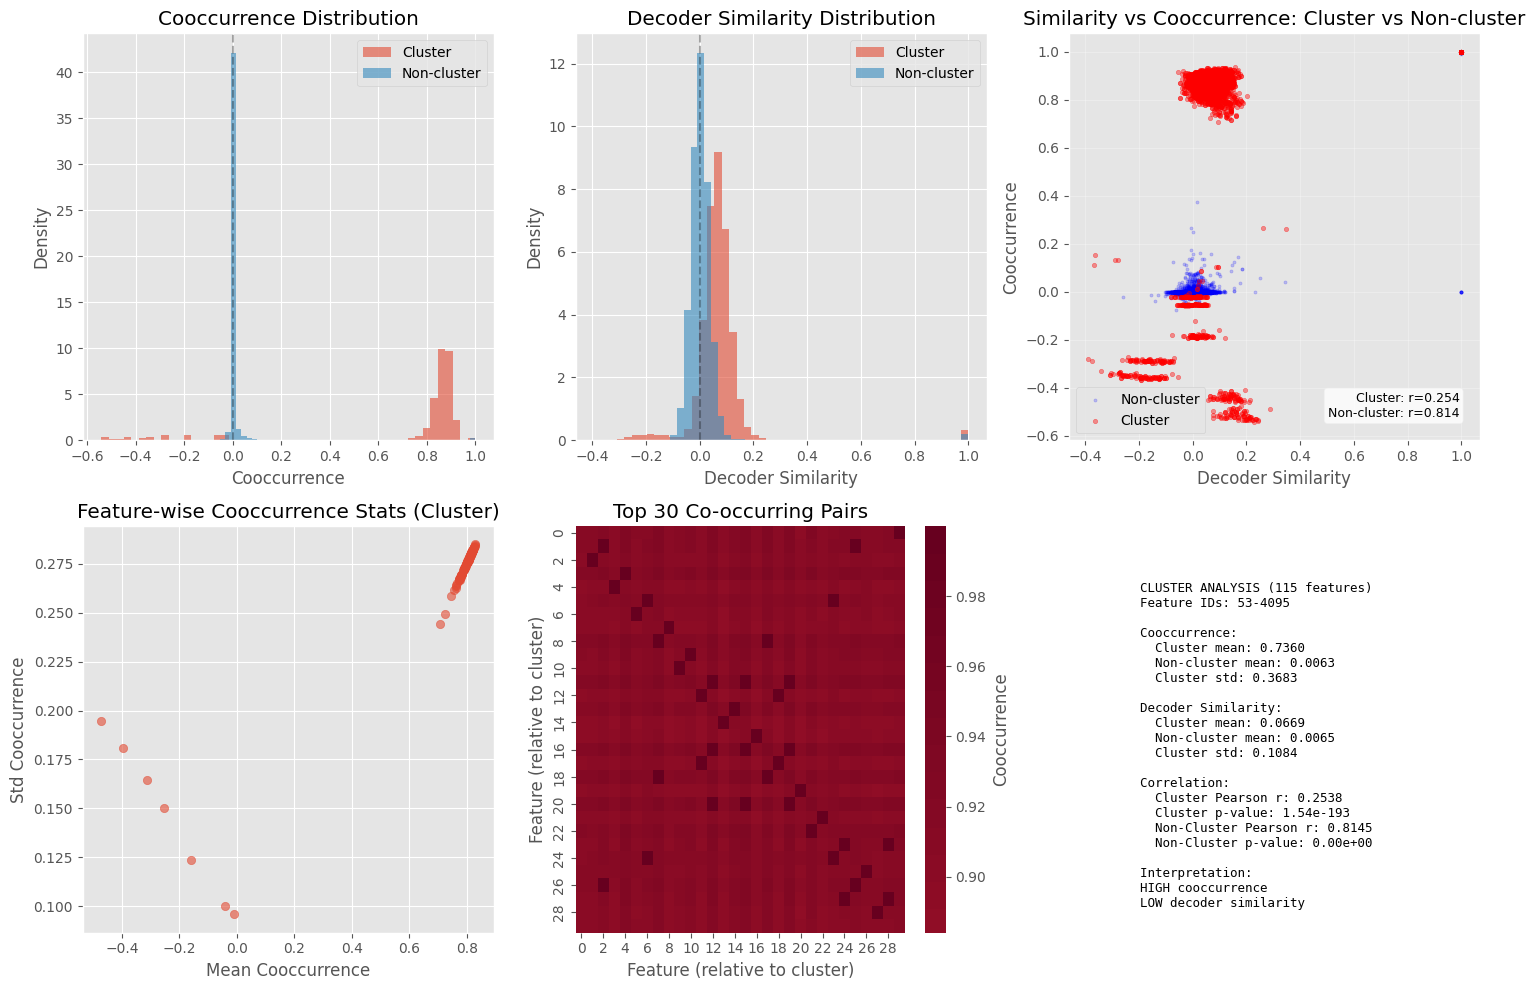


2. Analyzing activation patterns...


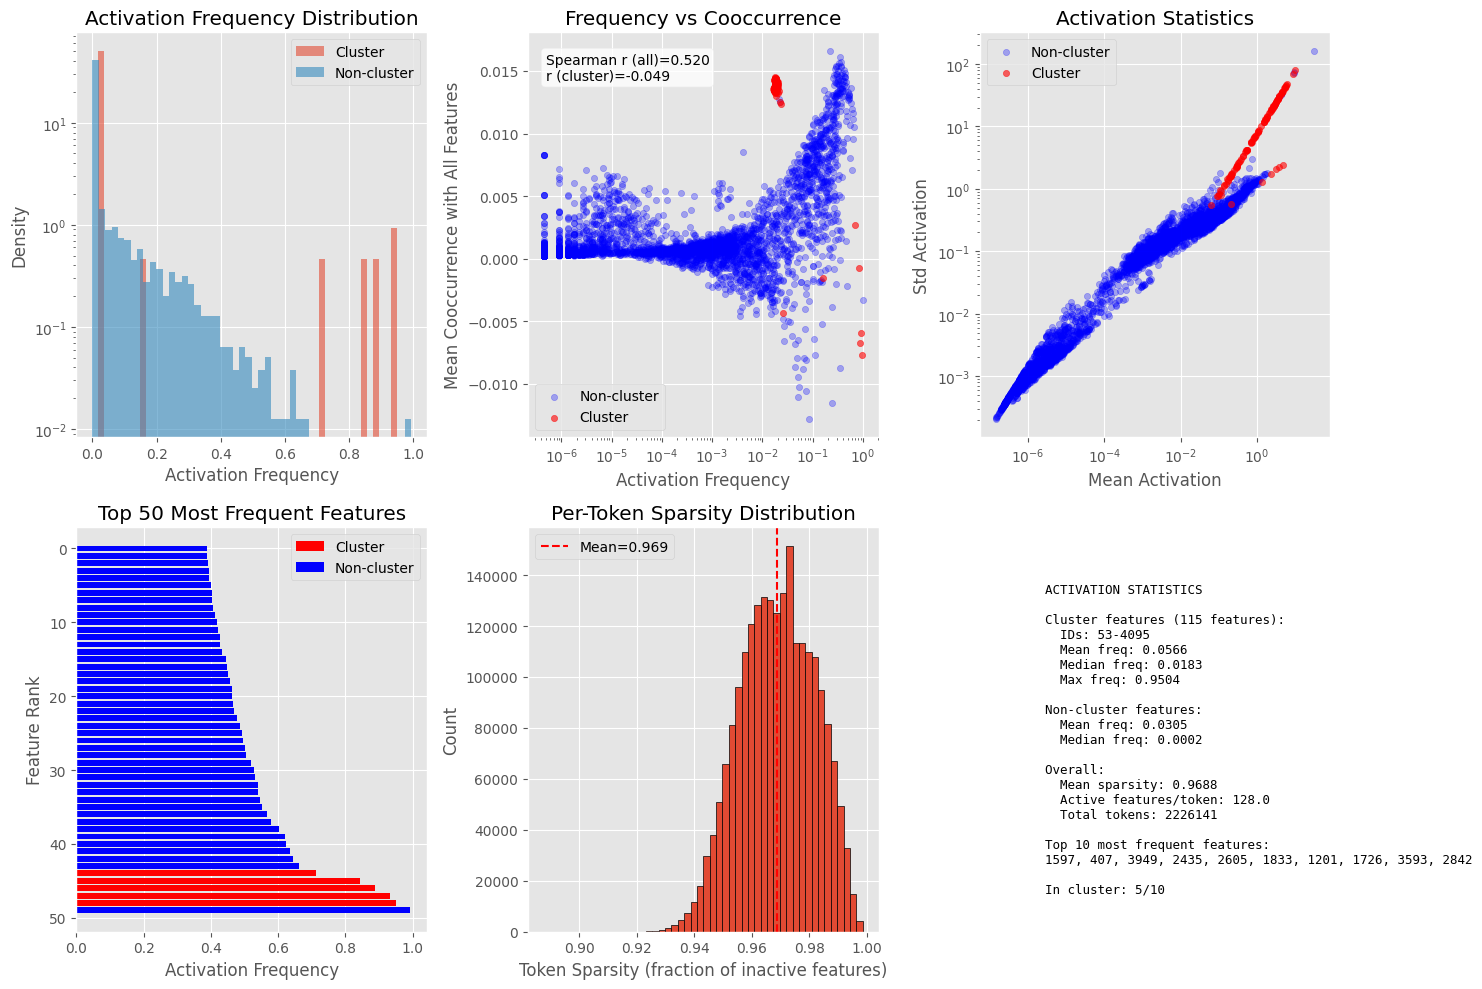


3. Analyzing decoder geometry...


/Users/deancasey/opt/anaconda3/envs/env312/lib/python3.12/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: divide by zero encountered in divide
  return n/db/n.sum(), bin_edges
/Users/deancasey/opt/anaconda3/envs/env312/lib/python3.12/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


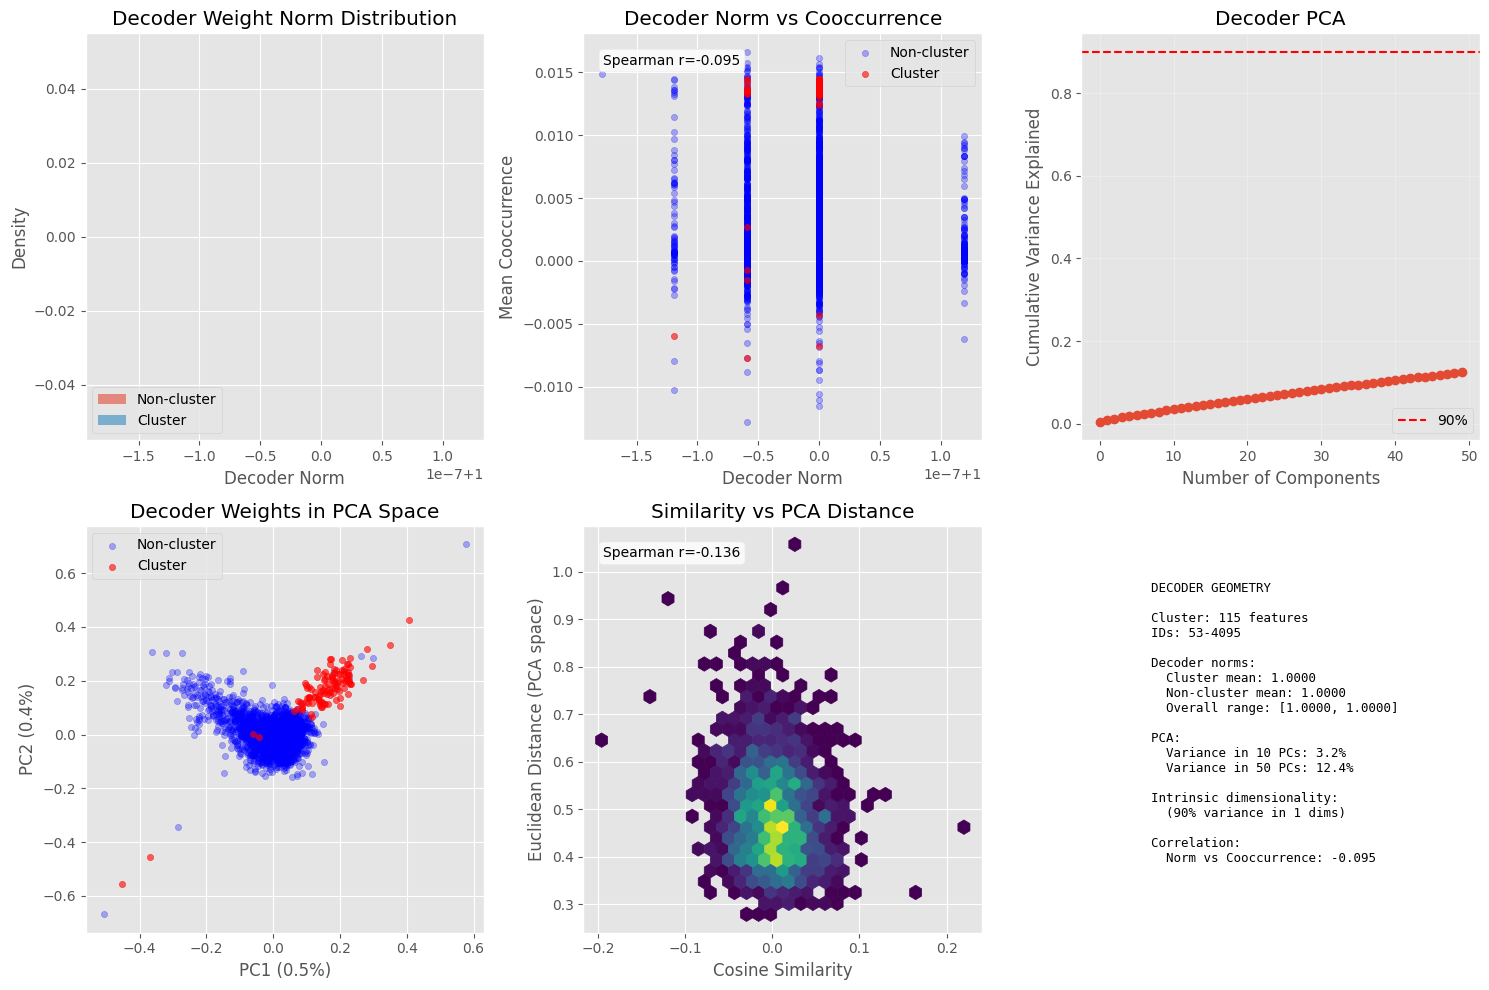


4. Creating feature interaction network...

Network Statistics:
  Nodes: 74
  Edges: 1032
  Average degree: 27.89
  Clustering coefficient: 0.8018
  Connected components: 1

Top 10 most connected features:
    Feature 1832: 73 connections [cluster: ✗]
    Feature 0: 67 connections [cluster: ✗]
    Feature 3363: 66 connections [cluster: ✓]
    Feature 2207: 66 connections [cluster: ✗]
    Feature 3395: 62 connections [cluster: ✓]
    Feature 3842: 62 connections [cluster: ✓]
    Feature 3143: 59 connections [cluster: ✓]
    Feature 73: 56 connections [cluster: ✓]
    Feature 731: 55 connections [cluster: ✓]
    Feature 2141: 53 connections [cluster: ✓]


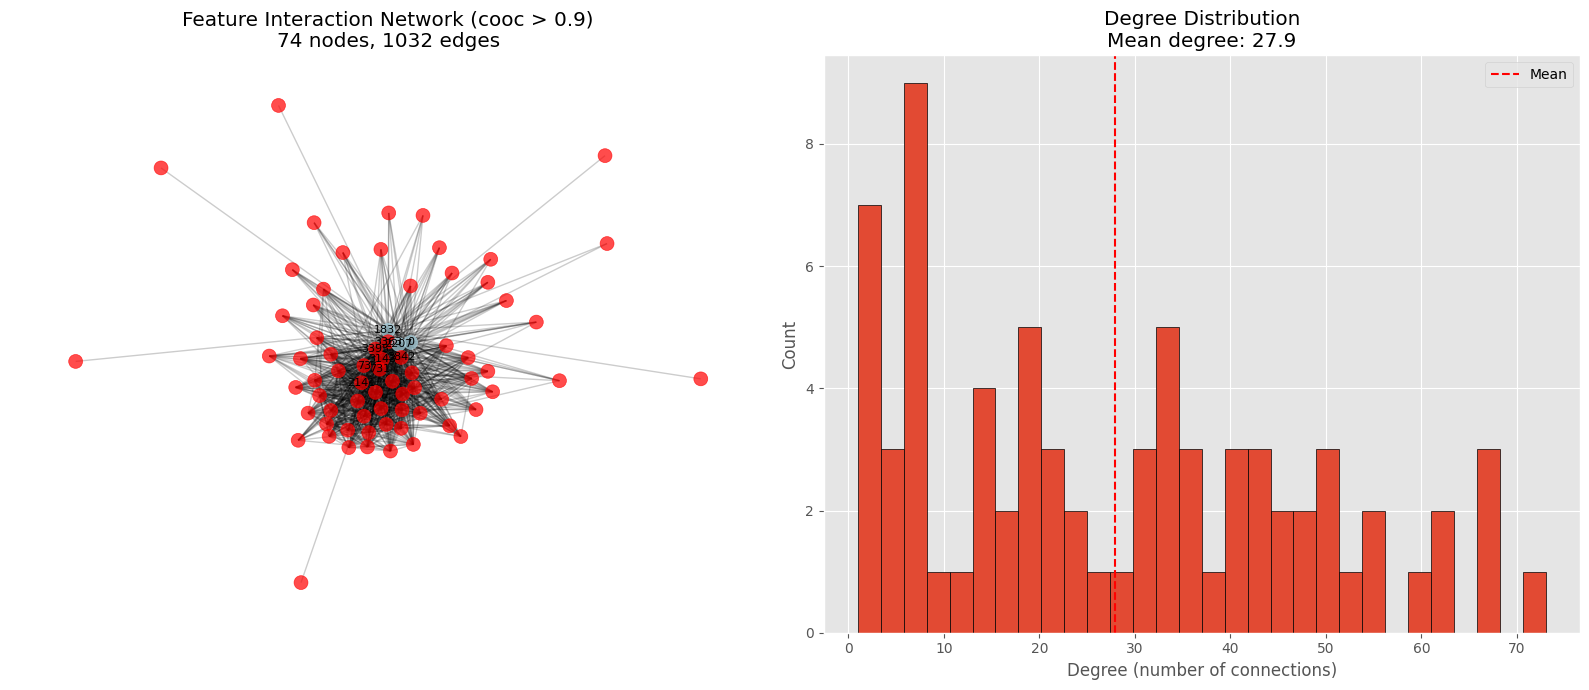


DIAGNOSTICS COMPLETE


In [65]:
decoder_weights = sae.W_dec.detach().cpu().numpy()  # Adjust based on your SAE structure

# Get the actual cluster feature IDs
actual_cluster_features = ordered_idx[15:130]

# Run diagnostics
results = run_full_diagnostics(
    cooccurrence_matrix=cooccurrence_matrix,
    similarity_matrix=similarity_matrix,
    activation_matrix=activation_matrix,
    decoder_weights=decoder_weights,
    cluster_features=actual_cluster_features,
    plot_dir=plot_dir
)

In [45]:
# Get the actual cluster feature IDs from the heatmap
cluster_start_pos = 15
cluster_end_pos = 130
actual_cluster_features = ordered_idx[cluster_start_pos:cluster_end_pos]

print(f"Actual cluster contains {len(actual_cluster_features)} features")
print(f"Feature IDs range from {actual_cluster_features.min()} to {actual_cluster_features.max()}")
print(f"First 20 feature IDs in cluster: {actual_cluster_features[:20]}")
print(f"Are they contiguous? {np.array_equal(actual_cluster_features, np.arange(actual_cluster_features.min(), actual_cluster_features.max()+1))}")

Actual cluster contains 115 features
Feature IDs range from 53 to 4095
First 20 feature IDs in cluster: [3907 4066 2605 1833 1201 1726 3593 3750  179 1669  703  503  875 1366
 1227 2697 2641 1772 3694  406]
Are they contiguous? False


In [166]:
# 1. What are these features capturing?
print("Cluster feature IDs:")
print(actual_cluster_features)

Cluster feature IDs:
[3907 4066 2605 1833 1201 1726 3593 3750  179 1669  703  503  875 1366
 1227 2697 2641 1772 3694  406  615  998 1993 3997 1251  584 2908 2421
 1663 1425 3025 3626 2145  526  511 2937 1898  622 1169 1996 4070 2637
  453 2216 2682  126 1995 2255  821 2175  598  799  769  876 2511 3688
 3187 2336 2213 3345  961  166  378 3656 4095 3249 3287 1910 2432  430
 4087 1550 3993 1429 2916  206 2781 1060 2966   95  605 1881  494 1368
  138 2796 3942 2715 3669   53 2335 4090 4004 2535 3912  650 2702 3987
 3125 3142  411  731 3413 2524 2899 3523  412 1057 3143   73 2141 3286
 3842 3395 3363]


In [67]:
positions = [ex["position"] for _, r in df[df.feature.isin(actual_cluster_features)].iterrows() for ex in r["top_examples"] if ex.get("position") is not None]
print(pd.Series(positions).value_counts().sort_values(ascending=False), "\nfraction at pos 0:", np.mean(np.array(positions) == 0))

0      2697
1         7
7         6
20        5
19        5
       ... 
85        1
13        1
428       1
68        1
157       1
Name: count, Length: 103, dtype: int64 
fraction at pos 0: 0.9380869565217391


In [ ]:
# Human-labeled features from this cluster: (poly means that its a polysemantic feature, and poly(decay) means that it basically has the same set of features 
# - the decay is just the first token of that set of features that keeps getting repeated)
#['and', poly(non-domain), poly(bio), poly(non-domain), poly(non-domain/'example'), 'of', 'proportion', poly(decay), poly(decay),
# poly(decay), poly(decay), '#', poly(decay), poly(.#0%), poly(decay/slightly different), poly(slightly different), poly(decay),
# '8', poly(decay), poly(g/h), '8/None', 'These', 'State', poly(decay), decay/These, poly(decay/'('), poly(decay/slightly different)
# poly(decay), poly(decay), poly(decay), poly(decay), poly(decay), poly(decay), poly(decay), poly(?), poly(decay), poly('#'), poly(decay),
# 'Not', 'M'/'Answers', poly(slightly different), poly(decay), poly(decay), poly(slightly different), 'Even'/'Unlike', poly(decay), '2'/'0',
#  poly(?), 'These', poly(decay), 'TABLE', poly(?), poly(decay), 'What', poly(decay), poly(?), poly(decay), poly(decay), 'INT', poly(decay),
# poly(decay), '(', poly(bio), poly(slightly different), poly(?), 'the', poly(decay), poly(decay), poly(decay/slightly different), 'INT',
# poly('State'), poly(decay), poly(decay), 'You', 'the',  poly(decay), 'the', poly(decay), 'the', 'Chem', '#', poly(decay), '9'/'0', 'FIG',
# 'Sex'/'Similar', poly(Rel), poly(<table), 'Unlike', poly(decay), poly(decay), '(', poly(decay), poly(decay), 'State', poly(decay), poly(decay),
# poly(decay), poly(decay), '8'/'0', poly(decay), poly(decay), poly(decay), poly(decay), poly(decay), poly(decay), poly(decay), poly(decay),
# poly(decay), poly(decay), poly(decay), poly(decay), poly(decay)]

In [187]:
feature_id = 3750
print("Token counts:")
display(token_counts(feature_id))
print("Top contexts:")
show_feature(feature_id, n_examples=5)

Token counts:


hap            3
None           2
CTL            2
composition    1
environment    1
Transparent    1
vascular       1
Protection     1
-linked        1
Gener          1
overall        1
decay          1
scientific     1
species        1
entropy        1
dtype: int64

Top contexts:
feature=3750 activation=737.607 pos=0 text_idx=23901 token='decay'
[decay]  rate    with    the  decay  constant  for  the  particular  radio is otope

feature=3750 activation=727.801 pos=0 text_idx=24338 token='scientific'
[scientific]  papers  published  in  scientific  journals .  A  scientific  research  paper  consists  of  several  well defined  sections :  introduction ,  materials

feature=3750 activation=722.792 pos=0 text_idx=30871 token='ABA'
[ABA]  induces  dorm ancy  in  seeds  by  blocking  ger mination  and  promoting  the  synthesis  of  storage  proteins .  Plants  adapted  to

feature=3750 activation=718.801 pos=0 text_idx=34724 token='hab'
[hab] its  of  warm -blood ed  versus  cold -blood ed  animals .  Modeling  of  ecosystem  energy  is  best  done  with  ecological

feature=3750 activation=717.872 pos=0 text_idx=28847 token='sexual'
[sexual]  reproduction ,  and  is  in  many  ways  a  typical  e uk ary otic  nucleus ,  except  that  its  genes  are

In [71]:
print("Top by activation_frequency")
top_freq = df.nlargest(20, "activation_frequency")["feature activation_frequency mean_activation num_examples".split()]
display(top_freq)

Top by activation_frequency


,feature,activation_frequency,mean_activation,num_examples
2393,2842,"2,210,975.000",31.674,25
3043,3593,"2,115,723.000",4.928,25
1444,1726,"2,075,604.000",3.992,25
1005,1201,"1,974,481.000",3.528,25
1536,1833,"1,877,215.000",2.797,25
2194,2605,"1,585,669.000",1.934,25
2046,2435,"1,470,583.000",2.691,25
3340,3949,"1,433,540.000",2.511,25
344,407,"1,413,036.000",2.454,25
1332,1597,"1,386,946.000",2.573,25


In [ ]:
feature_id = 2927
print("Token counts:")
display(token_counts(feature_id))
print("Top contexts:")
show_feature(feature_id, n_examples=5)

In [80]:
feature_id = 2927
print("Token counts:")
display(token_counts(feature_id))
print("Top contexts:")
show_feature(feature_id, n_examples=25)

Token counts:


living    18
life       2
Living     2
alive      1
matter     1
Energy     1
dtype: int64

Top contexts:
feature=2927 activation=14.347 pos=8 text_idx=24364 token=' living'
1 1 .  Vir uses  are  not  considered  [living]  because  they a .  are  not  made  of  cells  b .  lack  cell  nuclei  c .  do  not  contain  DNA

feature=2927 activation=12.771 pos=50 text_idx=25292 token=' living'
ed  and  only  can  pass  through  due  to  specialized  proteins  such  as  channels  and  transport ers .  The  chemistry  of  [living]  things  occurs  in  aque ous  solutions ,  and  balancing  the  concentrations  of  those  solutions  is  an  ongoing  problem .  In

feature=2927 activation=12.716 pos=16 text_idx=24366 token=' living'
a .  pro k ary otic  cells  b .  e uk ary otic  cells  c .  [living]  organisms  d .  bacteria

feature=2927 activation=12.559 pos=58 text_idx=24278 token=' living'
 example ,  a  branch  of  biology  called  vi ro logy  studies  viruses ,  which  exhibit  some  of  the  characteristics  of  [living]  entities  but  lack  others .  Although  viruses  can  a

In [74]:
feature_id = 141
print("Token counts:")
display(token_counts(feature_id))
print("Top contexts:")
show_feature(feature_id, n_examples=5)

Token counts:


turtles       10
wrink          6
apy            5
jelly          2
underwater     1
rept           1
dtype: int64

Top contexts:
feature=141 activation=11.267 pos=41 text_idx=30476 token=' turtles'
 cro cod iles ,  l izards ,  and  snakes .  There  are  about   3 2 5  living  species  of  [turtles]  and  tort o ises .  Like  other  rept iles ,  turtles  are  ect other ms .  All  turtles  are  ov

feature=141 activation=11.005 pos=83 text_idx=27983 token=' turtles'
.  For  some  species ,  the  environment  determines  some  major  characteristics ,  such  as  sex .  For  example ,  some  [turtles]  and  other  rept iles  have  temperature -dependent  sex  determination  ( T SD ).  T SD  means  that  individuals  develop  into

feature=141 activation=10.992 pos=59 text_idx=26611 token=' wrink'
3  yellow : 1  green ).  The  probability  for  shape  occupies  the  second  row  ( 3  round :   1  [wrink] led ),  and  the  probability  for  height  occupies  the  third  row  ( 3  tall : 1  dwarf ).  The  probability

feature=141 activation=10.798 pos=322 text_idx=26507 token=' wrink'
 colspan = 1 > Seed 